# Source Injection Demo

This demo notebook injects synthetic Sérsic sources into a single DC2 simulated image.

A summary of data processing steps:
1. Instantiate a butler and load an image for source injection;
2. Set up an input source injection catalogue and ingest it into the data repository;
3. Run the source injection task and generate simple analysis plots.

## Imports

First, we import all necessary packages used in this notebook.

We also configure `afwDisplay`, the LSST image plotting package, to use `matplotlib`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.ndimage import gaussian_filter

from lsst.daf.butler import Butler, DimensionUniverse, DatasetType, CollectionType
from lsst.daf.butler.registry import MissingCollectionError
import lsst.afw.display as afwDisplay
from lsst.source.injection.inject_visit import VisitInjectConfig,VisitInjectTask

afwDisplay.setDefaultBackend("matplotlib")

## Instantiate a butler

We now instantiate the `butler`. The `butler` is used to search the on-disk repository (the '`repo`') to find and access ingested data.

In [2]:
repo = "/repo/dc2"

butler = Butler(repo)

## Query collections to locate an input collection

For the purposes of this demo, we shall first search the `butler` `registry` to find an input `DP0.1` RUN collection.

In [3]:
collections = sorted(list(set(
    butler.registry.queryCollections("2.2i/runs/DP0.1*")
)))

display(collections)

input_collection = collections[0]

print(f"{input_collection = }")

['2.2i/runs/DP0.1',
 '2.2i/runs/DP0.1/calexp/v1',
 '2.2i/runs/DP0.1/coadd/wfd/dr6/v1',
 '2.2i/runs/DP0.1/coadd/wfd/dr6/v1/grizy',
 '2.2i/runs/DP0.1/coadd/wfd/dr6/v1/u']

input_collection = '2.2i/runs/DP0.1'


## Query datasets to locate an input calexp

Next, we find a DC2 Processed Visit Image (PVI or '`calexp`') to inject into. For the purposes of this demo, this could be any exposure. Here we search for all detector=1 `calexp`s within our collection.

Only `calexp`s within tract 3828 (one of the regularly processed tracts) are considered.

A single DatasetRef in the list is selected for source injection.

In [4]:
tract = 3828

calexp_DatasetRefs = sorted(list(set(
    butler.registry.queryDatasets(
        "calexp",
        collections=input_collection,
        where=f"instrument='LSSTCam-imSim' AND skymap='DC2' AND tract={tract} AND detector=1",
))))

print(f"Identified {len(calexp_DatasetRefs)} calexp DatasetRefs")

display(calexp_DatasetRefs[5])

dataId = calexp_DatasetRefs[5].dataId

print(f"{dataId = }")

Identified 156 calexp DatasetRefs


DatasetRef(DatasetType('calexp', {band, instrument, detector, physical_filter, visit}, ExposureF), {instrument: 'LSSTCam-imSim', detector: 1, visit: 169838, ...}, id=eec1ed0a-d85f-4b72-8456-d22495a91921, run='2.2i/runs/DP0.1/calexp/v1')

dataId = {instrument: 'LSSTCam-imSim', detector: 1, visit: 169838, ...}


## Load the input calexp

Use the `butler` to load the `calexp` into an object.

In [5]:
calexp = butler.get("calexp", dataId=dataId, collections=input_collection)

display(calexp)

## Plot the input calexp

Lets generate a plot of this `calexp` and its associated `mask`.

First, we smooth the `calexp` image (for the purpose of aiding its display in this notebook).

Then, we use `afwDisplay` to display these data.

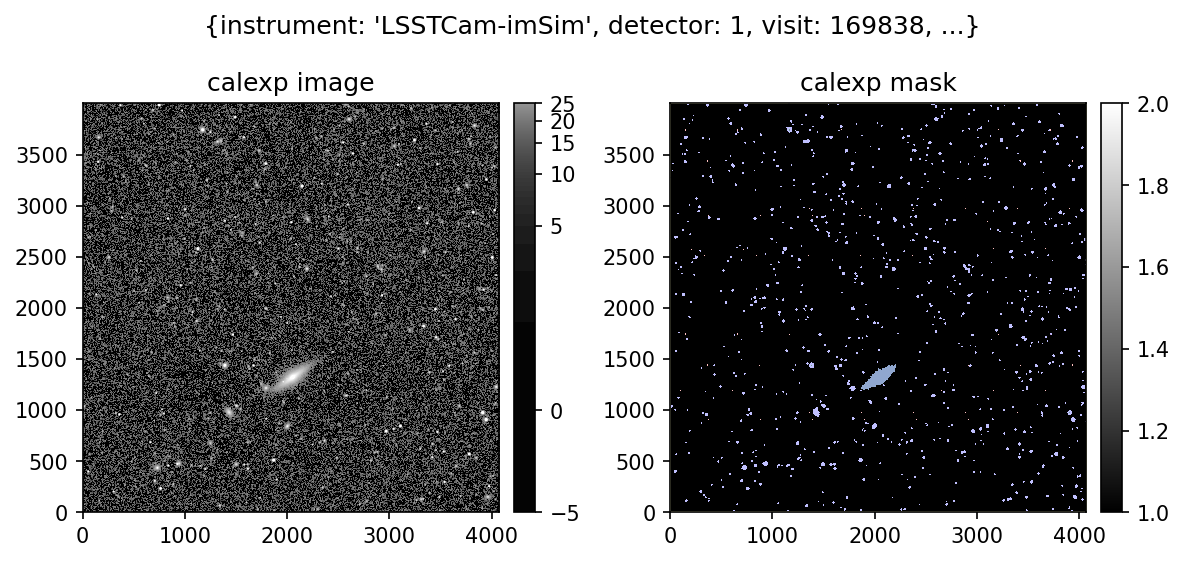

In [6]:
Q = 10

plot_calexp = calexp.clone()
plot_calexp.image.array = gaussian_filter(calexp.image.array, sigma=3)

fig, ax = plt.subplots(1, 2, figsize=(8, 6), dpi=150)

plt.sca(ax[0])
display0 = afwDisplay.Display(frame=fig)
display0.scale("asinh", min=-5/Q, max=25/Q, Q=Q)
display0.mtv(plot_calexp.image)
plt.title("calexp image")

plt.sca(ax[1])
display1 = afwDisplay.Display(frame=fig)
display1.scale("linear", min=1, max=2)
display1.mtv(plot_calexp.mask)
plt.title("calexp mask")

plt.suptitle(str(dataId), y=0.8)
plt.tight_layout()
plt.show()

## Set up a synthetic source input catalogue

We now have a `calexp` image that we want to inject into. Next we need to set up a simple synthetic source catalogue.

In this notebook, we opt to inject 100 synthetic Sérsic sources into the detector.

In [7]:
np.random.seed(0)

nsource = 100

x = np.random.uniform(0, calexp.getBBox().endX, nsource)
y = np.random.uniform(0, calexp.getBBox().endY, nsource)
ra, dec = calexp.wcs.pixelToSkyArray(x, y, degrees=True)

si_cat = pd.DataFrame(dict(
    ra=ra,
    dec=dec,
    mag=np.random.uniform(15, 25, nsource),
    semimajor=np.random.uniform(1, 10, nsource),
    axis_ratio=np.random.uniform(0.5, 1, nsource),
    pa=np.random.uniform(0, 180, nsource),
    n=np.random.uniform(0.5, 4, nsource),
    source_type="galaxy",
))

display(si_cat[:5])

,ra,dec,mag,semimajor,axis_ratio,pa,n,source_type
0,57.497801,-35.596783,18.117959,9.158999,0.700630,55.868549,1.111304,galaxy
1,57.377446,-35.600046,21.963435,7.966426,0.964646,67.146275,1.647958,galaxy
2,57.505786,-35.580426,18.777518,3.998306,0.549807,94.494680,2.881220,galaxy
3,57.568755,-35.571419,16.796037,1.729913,0.972651,135.107104,0.721227,galaxy
4,57.405833,-35.661891,15.246787,4.665171,0.934744,60.031344,2.625373,galaxy


## Register the source injection collection

The input `si_cat` will be ingested into a RUN collection in the `repo`. Here we register this collection for subsequent use below.

To begin, we first instantiate a writable `butler`. Butlers are instantiated in read-only mode by default. By setting the argument `writeable` to `True`, a butler can also be made to be writeable.

> Warning: take care when working with a writeable butler, as data on-disk has the potential to be permanently removed or corrupted.

As a precaution, we attempt to remove our chosen RUN collection if it exists before continuing with processing. If we attempt to inject synthetic sources into a collection which already exists, the task will complain that the output data already exist on disk.

Finally, the source injection collection is registered in the `repo`.

In [8]:
writeable_butler =  Butler(repo, writeable=True)

si_input_collection = "u/lskelvin/si_demo"

try:
    writeable_butler.removeRuns([si_input_collection])
except MissingCollectionError:
    print("Writing into a new RUN collection")
    pass
else:
    print("Prior RUN collection located and successfully removed")

_ = writeable_butler.registry.registerCollection(si_input_collection, type=CollectionType.RUN)

Prior RUN collection located and successfully removed


## Register the input catalogue dataset type

Here we define the `si_cat` dataset type, which lets the `repo` know about the dimensions and storage class for these synthetic source data.

Using this definition, the new dataset type is registered in the `repo` using `registerDatasetType`. This method returns True if the datasetType was inserted, and False if an identical existing DatsetType was found.

In [9]:
si_dataset_type =  DatasetType(
    "si_cat",
    dimensions=["skymap", "tract"],
    storageClass="DataFrame",
    universe=DimensionUniverse(),
)

writeable_butler.registry.registerDatasetType(si_dataset_type)

False

## Ingest the input catalogue into the repo

Finally, we ingest the input catalogue into the `repo`.

In [10]:
si_dataId = dict(tract=tract, skymap="DC2")

writeable_butler.put(si_cat, si_dataset_type, si_dataId, run=si_input_collection)

DatasetRef(DatasetType('si_cat', {skymap, tract}, DataFrame), {skymap: 'DC2', tract: 3828}, id=4b6ae682-f4c2-48ea-8f26-bef303c4a5f3, run='u/lskelvin/si_demo')

## Instantiate the injection classes

At this stage, we have an input image and we have a fully ingested synthetic source input catalogue. We're now ready to inject synthetic sources into the image using the tools available in the `source_injection` repo.

First, we instantiate the `VisitInjectConfig` class. The `VisitInjectConfig` class is where configuration of the injection task occurs, allowing for modifications to be made to how the task operates.

Following this, we then instantiate the `VisitInjectTask`, using `inject_config` as the configuration argument.

In [11]:
inject_config = VisitInjectConfig()

display(inject_config)

inject_task = VisitInjectTask(config=inject_config)

lsst.source.injection.inject_visit.VisitInjectConfig(saveMetadata=True, saveLogOutput=True, doApplyExternalTractPhotoCalib=False, doApplyExternalGlobalPhotoCalib=False, externalPhotoCalibName='jointcal', doApplyExternalTractSkyWcs=False, doApplyExternalGlobalSkyWcs=False, externalSkyWcsName='jointcal', doCleanCat=True, calibFluxRadius=9.0, doProcessAllDataIds=False, trimBuffer=100, fits_alignment='pixel', doSourceSelect=False, doMatchVisit=False, doInjectImages=False, ra_col='ra', dec_col='dec', mag_col='%s_mag', semimajor_col='semimajor', axis_ratio_col='axis_ratio', pa_col='pa', n_col='n', source_type_col='source_type', select_col='select', visit_col='visit', image_col='%s_image', connections={'skyMap': 'skyMap', 'injectionCatalogs': '{siPrefix}cat', 'externalPhotoCalibTractCatalog': '{photoCalibName}PhotoCalibCatalog', 'externalPhotoCalibGlobalCatalog': '{photoCalibName}PhotoCalibCatalog', 'externalSkyWcsTractCatalog': '{wcsName}SkyWcsCatalog', 'externalSkyWcsGlobalCatalog': '{wcsNa

## Generate a deferred dataset handle

The visit inject task requires the input catalogue to be in the form of a 'deferred dataset handle'.

A deferred dataset handle is an object which performs an immediate registry lookup but does not immediately retrieve the data, allowing for that data to be subsequently accessed as needed.

> Note: Prior to running `getDeferred` below, we first re-instantiate the `butler`. This updates the registry, allowing us to make use of our newly constructed source injection RUN collection.

In [12]:
butler = Butler(repo)

si_cat_deferred = butler.getDeferred("si_cat", dataId=si_dataId, collections=si_input_collection)

display(si_cat_deferred)

DeferredDatasetHandle(butler=<lsst.daf.butler._butler.Butler object at 0x7fe757f80520>, ref=DatasetRef(DatasetType('si_cat', {skymap, tract}, DataFrame), {skymap: 'DC2', tract: 3828}, id=4b6ae682-f4c2-48ea-8f26-bef303c4a5f3, run='u/lskelvin/si_demo'), parameters=None)

## Run the source injection task

Finally, we run the `run` method of the inject task.

As an input, the run method needs:
* the input injection catalogue
* the input exposure
* the WCS information
* the photometric calibration information
* the skyMap dataset type.

The skyMap is easily loaded using `butler.get`. All other inputs are ready for use at this stage.

As an output, the inject task provides:
* the output exposure with sources injected
* the output source injection catalogue

The output source injection catalogue is identical to the input, excepting two additonal columns (`x` and `y`) which denote the pixel coordinates of these sources. Note that this catalogue is NOT the science catalogue containing the full suite of LSST Science Pipelines outputs. To get that, this source injected image will need to be processed by additional standard Science Pipelines tasks (not discussed in this notebook).

> Note: here we use a clone of the input `calexp`. This is because the `calexp` is edited in-place, so inputting a clone allows us to continue using the original `calexp` later in this notebook.

In [13]:
skyMap = butler.get("skyMap", collections=input_collection, skymap="DC2")

inject_output = inject_task.run(
    injectionCatalogs=[si_cat_deferred],
    inputExposure=calexp.clone(),
    skyMap=skyMap,
    wcs=calexp.getWcs(),
    photoCalib=calexp.getPhotoCalib(),
)
si_calexp = inject_output.outputExposure
si_cat_out = inject_output.outputCat

display(si_cat_out[:5])

,ra,dec,mag,semimajor,axis_ratio,pa,n,source_type,x,y
0,57.497801,-35.596783,18.117959,9.158999,0.700630,55.868549,1.111304,galaxy,2234.768588,2711.266147
1,57.377446,-35.600046,21.963435,7.966426,0.964646,67.146275,1.647958,galaxy,2912.251100,1080.031893
2,57.505786,-35.580426,18.777518,3.998306,0.549807,94.494680,2.881220,galaxy,2454.452467,2940.776088
3,57.568755,-35.571419,16.796037,1.729913,0.972651,135.107104,0.721227,galaxy,2218.764321,3848.754180
4,57.405833,-35.661891,15.246787,4.665171,0.934744,60.031344,2.625373,galaxy,1725.122343,995.012574


## Plot the output si_calexp

As before, lets display an image of our newly constructed `si_calexp`.

We similarly smooth the new image first, and then display the `calexp` alongside the `si_calexp` using `afwDisplay`.

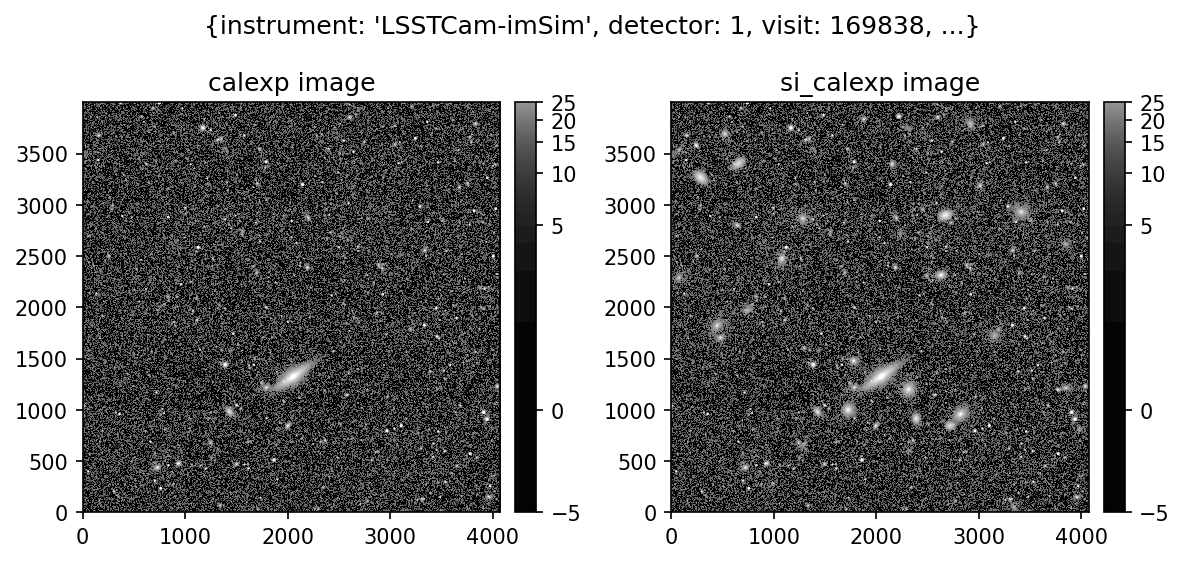

In [14]:
Q = 10

plot_si_calexp = si_calexp.clone()
plot_si_calexp.image.array = gaussian_filter(si_calexp.image.array, sigma=3)

fig, ax = plt.subplots(1, 2, figsize=(8, 6), dpi=150)

plt.sca(ax[0])
display0 = afwDisplay.Display(frame=fig)
display0.scale("asinh", min=-5/Q, max=25/Q, Q=Q)
display0.mtv(plot_calexp.image)
plt.title("calexp image")

plt.sca(ax[1])
display1 = afwDisplay.Display(frame=fig)
display1.scale("asinh", min=-5/Q, max=25/Q, Q=Q)
display1.mtv(plot_si_calexp.image)
plt.title("si_calexp image")

plt.suptitle(str(dataId), y=0.8)
plt.tight_layout()
plt.show()

## Plot a zoomed-in view of the si_calexp

Here is a zoomed in section of the above.

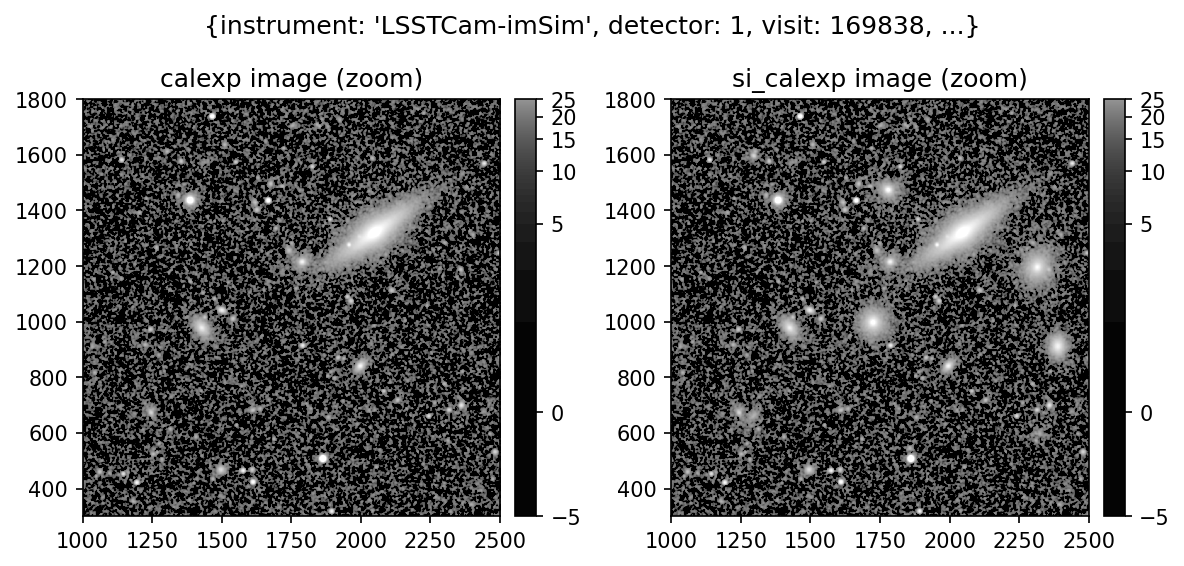

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(8, 6), dpi=150)

plt.sca(ax[0])
display0 = afwDisplay.Display(frame=fig)
display0.scale("asinh", min=-5/Q, max=25/Q, Q=Q)
display0.mtv(plot_calexp.image)
plt.title("calexp image (zoom)")
plt.xlim(1000, 2500)
plt.ylim(300, 1800)

plt.sca(ax[1])
display1 = afwDisplay.Display(frame=fig)
display1.scale("asinh", min=-5/Q, max=25/Q, Q=Q)
display1.mtv(plot_si_calexp.image)
plt.title("si_calexp image (zoom)")
plt.xlim(1000, 2500)
plt.ylim(300, 1800)

plt.suptitle(str(dataId), y=0.8)
plt.tight_layout()
plt.show()

## Plot a difference image

It may be useful to look at a difference image on occasion (with injected sources minus the original).

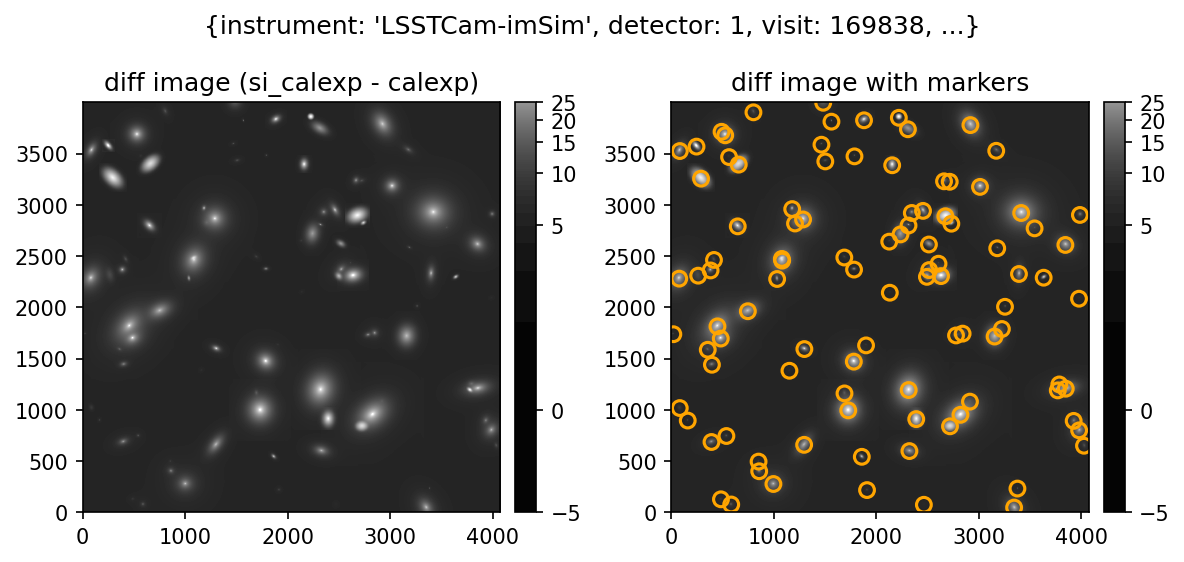

In [16]:
plot_diff_calexp = calexp.clone()
plot_diff_calexp.image.array = si_calexp.image.array - calexp.image.array

fig, ax = plt.subplots(1, 2, figsize=(8, 6), dpi=150)

plt.sca(ax[0])
display0 = afwDisplay.Display(frame=fig)
display0.scale("asinh", min=-5/Q, max=25/Q, Q=Q)
display0.mtv(plot_diff_calexp.image)
plt.title("diff image (si_calexp - calexp)")

plt.sca(ax[1])
display1 = afwDisplay.Display(frame=fig)
display1.scale("asinh", min=-5/Q, max=25/Q, Q=Q)
display1.mtv(plot_diff_calexp.image)
plt.title("diff image with markers")
plt.scatter(si_cat_out.x, si_cat_out.y, marker="o", s=50, fc="none", ec="orange", lw=1.5)

plt.suptitle(str(dataId), y=0.8)
plt.tight_layout()
plt.show()